In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json

from tqdm.notebook import tqdm

#sns.set_theme()

In [25]:
from datetime import datetime
import os

to_export = f'./Results/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}'
os.makedirs(to_export)

In [26]:
###################
### Parameters ###
###################

###############
## FOR MODEL ##
###############

data = {
'interest_rate' : 0.035,
'agents' : 500,
'periods' : 2000
}

################
## FOR AGENTS ##
################
data.update({
       
# Wealth distribution parameter: The higher, the lower the inequality
"inequality_wealth" : 5, 

# Skills distribution parameter: The higher, the lower the inequality
"inequality_skills" : 3,
"weight_gen_skills" : 0.5, # theta in the paper (Meritocracy)

# Qualities and varieties parameters
"qualities" : 20, # Q in the paper
"varieties" : 10, # J in the paper

# Own good pricing parameters
"a" : 0.2, # a in the paper, that says it should be strictly larger than 0.
"alpha" : 1.5, # alpha in the paper, that says it should be strictly larger than 1

# Connectivity limits, parameters
"min_connectivity" : 1, # This is the N^0 of the paper
"max_connectivity" : data['agents']-1 , # This is the \tilde{N} of the paper.

# Propensity to consume parameters
"pc_a" : 0.5, # a in the paper this a must be larger than 0.
"pc_c_l" : 0.1, # paper's c_l must be greater than 0 and lower than c_h
"pc_c_h" : 0.9, # paper's c_h must be larger than c_h but lower than 1.

# Connectivity update parameters
"connect_w" : 0.5, # w in the paper, must be >0, this reflects the importance of the change in wealth
"connect_b" : 0.5, # b in the paper, must be >0, this reflects the importance of the moral behavior

# Animal spirits parameters
"as_gamma" : 0.5, # gamma constant in the paper that states it should be in (0,1). Represents the importance of mean reversion.
"as_g" : 0.5, # g constant in the paper that states it should be in (0,1). Represents the importance of my friends.

# Moral behavior parameters
"mb_z" : 0.5, # constant z in the paper, reflects the influence of the peers, must be in (0,1)
"mb_zeta" : 0.5, # constant greek zeta in the paper, must be in (0,1) and weight of mean reversion.

# Political view parameters
"pv_x" : 0.5, # constant x in the paper must be in (0,1) and reflects influence of peers
"pv_omega" : 0.5 # constant omega in the paper must be in (0,1) reflects mean reversion
})

with open(f"{to_export}/latest_parameters.json", "w") as outfile: 
    json.dump(data, outfile)

In [27]:
from model import model

mymodel = model(data)

for _ in tqdm(range(data['periods'])):
    mymodel.step()

#############################
#   Get and store the data  #
#############################

results_model = mymodel.datacollector.get_model_vars_dataframe()
results_model.to_csv(f'{to_export}/results_model.csv')

results_agents = mymodel.datacollector.get_agent_vars_dataframe()
results_agents.to_csv(f'{to_export}/results_agents.csv')

  0%|          | 0/2000 [00:00<?, ?it/s]

In [28]:
df_model = results_model
df_agents = results_agents

In [29]:
number_of_agents = df_agents.loc[(1, slice(None)), :].shape[0]
number_of_periods = df_agents.loc[(slice(None), 1), :].shape[0]
print(f'We have a total of {number_of_agents} agents in the simulation, that ran for {number_of_periods-1} periods.')

n_rand_agents = 3
random_agents = random.sample(range(0, number_of_agents), n_rand_agents)

sample_agents = []

for i in random_agents:
    sample_agents.append(df_agents.loc[(slice(None) , i) , :].reset_index(level = 1, drop = True))

We have a total of 500 agents in the simulation, that ran for 2000 periods.


## Some random agents

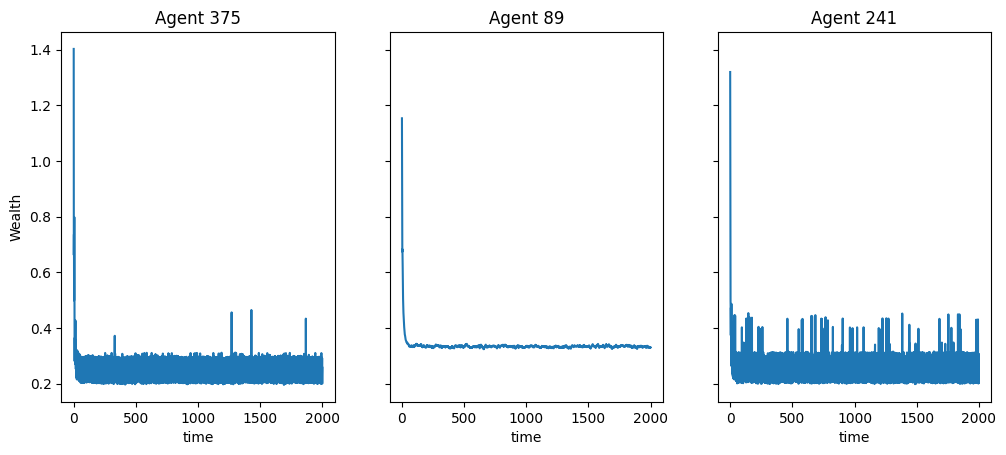

<Figure size 640x480 with 0 Axes>

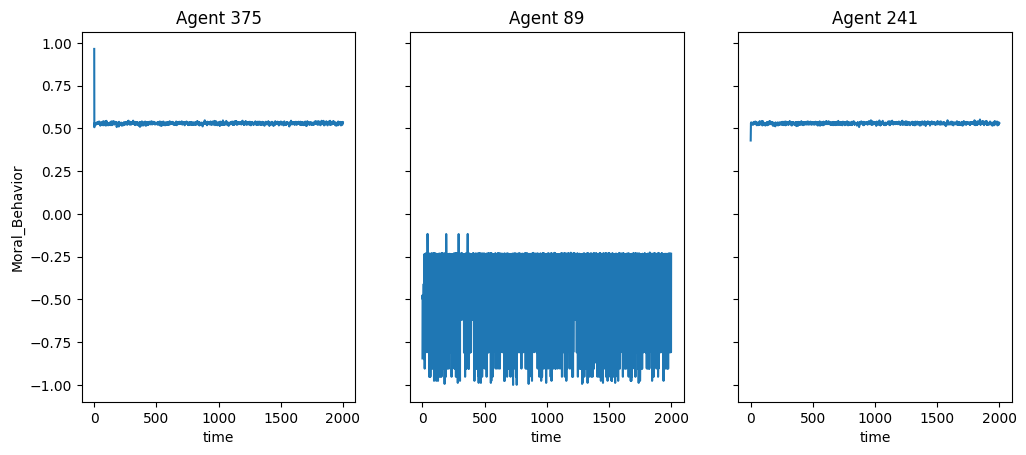

<Figure size 640x480 with 0 Axes>

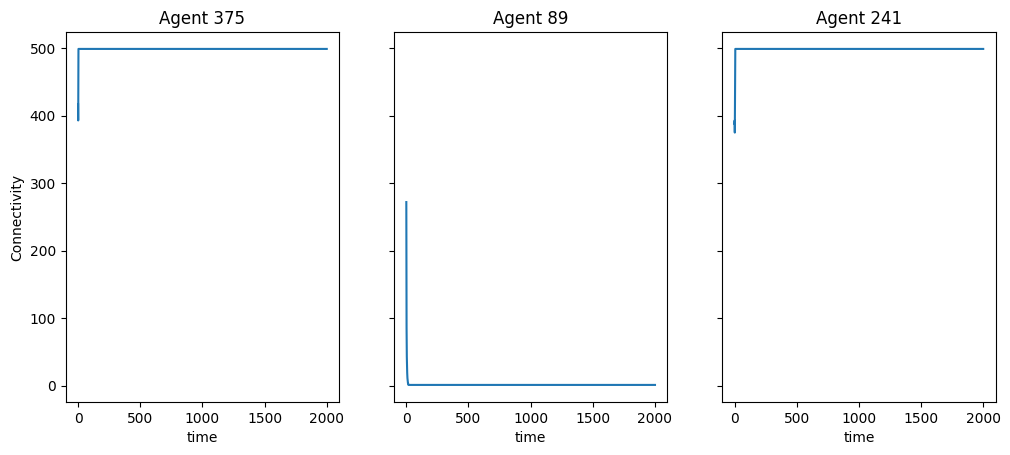

<Figure size 640x480 with 0 Axes>

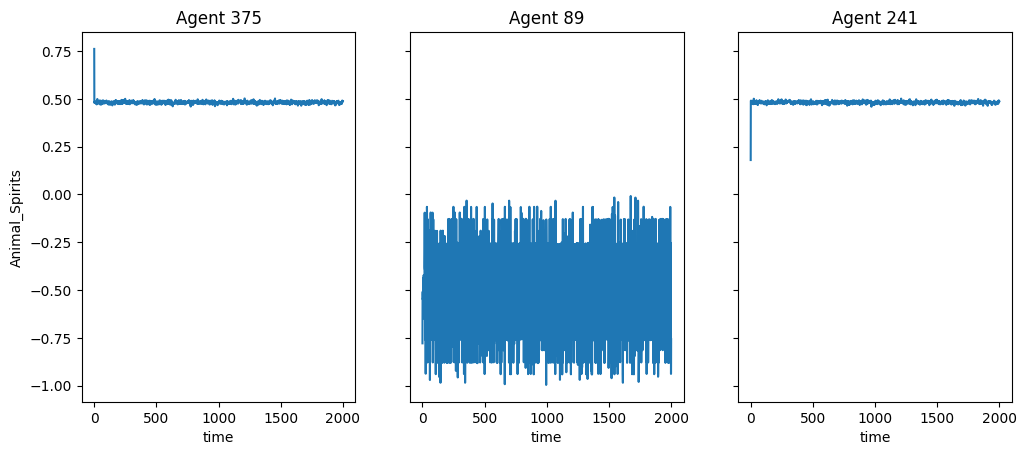

<Figure size 640x480 with 0 Axes>

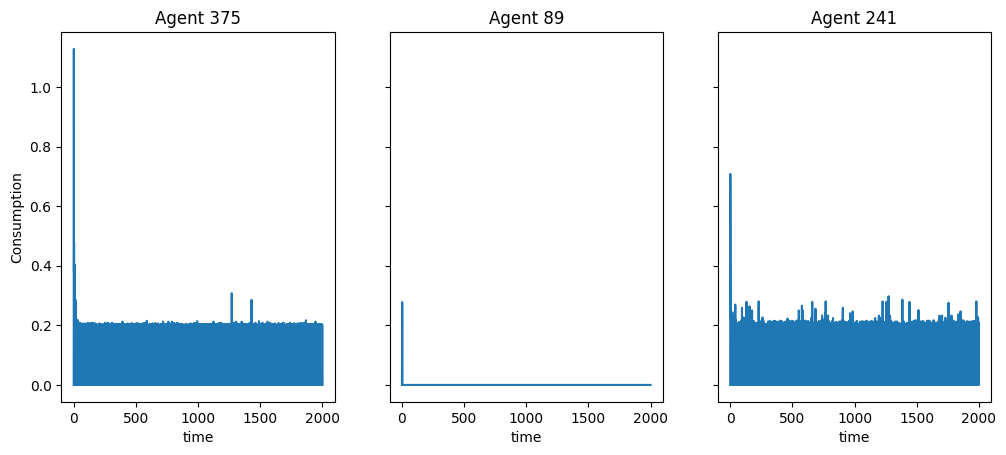

<Figure size 640x480 with 0 Axes>

In [30]:
vars_to_plot = ['wealth', 'moral_behavior', 'connectivity', 'animal_spirits', 'consumption']

for v in vars_to_plot:

    fig, ax = plt.subplots(nrows=1, ncols=len(random_agents), sharey = True);
    fig.set(figwidth = 12)

    ax[0].set_ylabel(str.title(v));

    for i in range(n_rand_agents):
        ax[i].plot(sample_agents[i][v]);
        ax[i].set_xlabel('time');
        ax[i].set_title(f'Agent {random_agents[i]}');
    
    plt.show()
    plt.savefig(f'{to_export}/sample_{v}.png')

## Distributions

In [31]:
def create_partitions(arr, n):
  size = len(arr)

  if n >= size:
    return list(range(size))
  elif size == 1:
    return [0]
  else:
    return [int(np.floor(i*(size-1)/(n-1))) for i in range(n)]

def make_hist(col):
  global steps
  subsample_cross = create_partitions(range(df_model.shape[0]), 3)

  plt.figure(figsize=(15, 15 ))
  plt.subplots_adjust(hspace=0.2)
  plt.suptitle(f"{str.title(col.replace('_',' '))}", fontsize=16, y=0.95)

  ncols = 3
  nrows = 3

  axes = []

  for n, ticker in enumerate(subsample_cross):
      if n == 0:
        axes.append(plt.subplot(nrows, ncols, n + 1))
      else:
        axes.append(plt.subplot(nrows, ncols, n + 1, sharey = axes[0]))
      axes[n].set_title(f't = {subsample_cross[n]}')
        
      df_agents.loc[(ticker, slice(None)), col].hist(ax = axes[n], bins = 20, weights = np.zeros_like(df_agents.loc[(ticker, slice(None)), col]) + 1./df_agents.loc[(ticker, slice(None)), col].size)

  plt.savefig(f'{to_export}/hist_{col}.png')

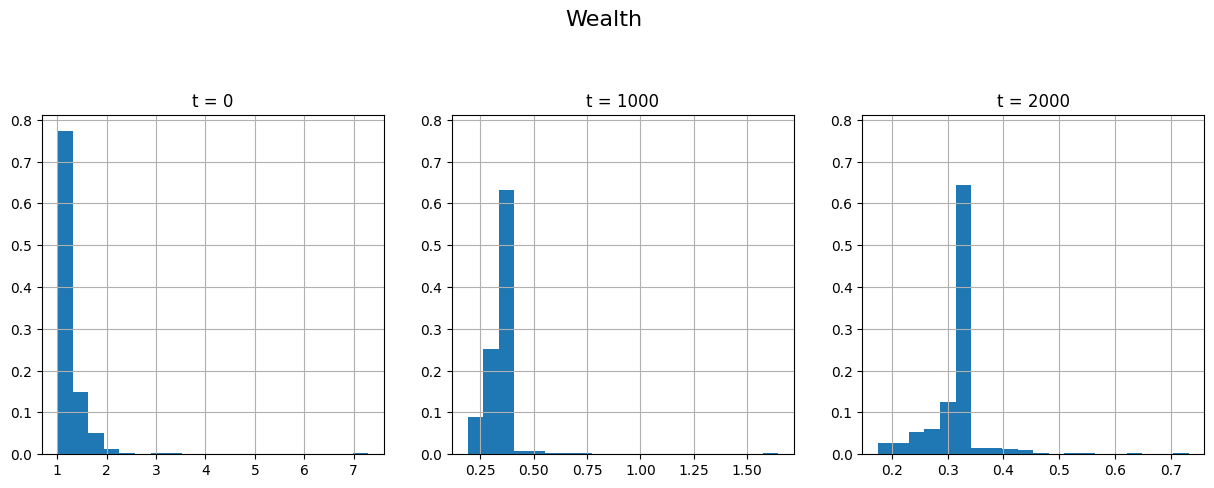

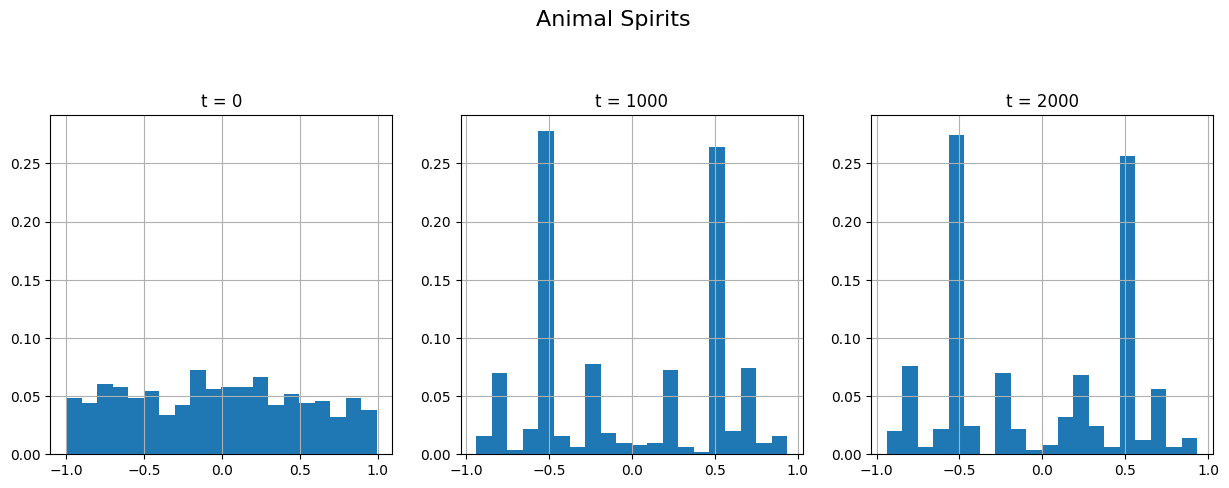

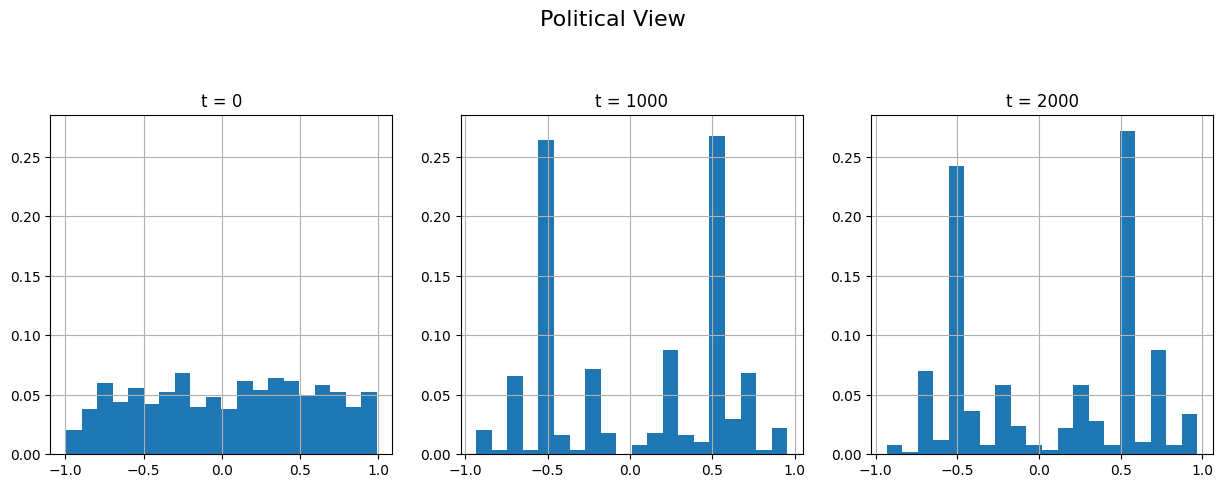

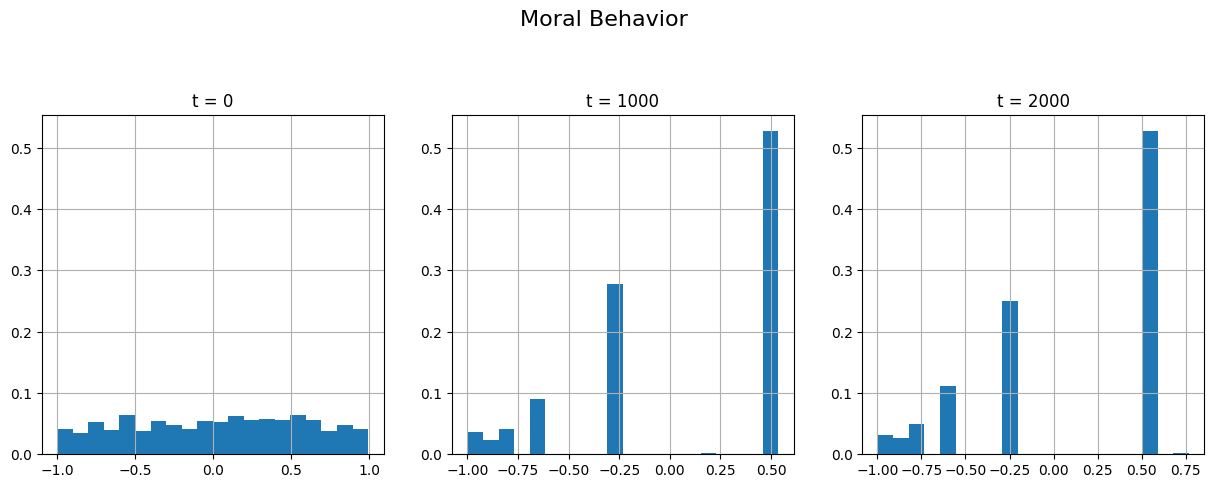

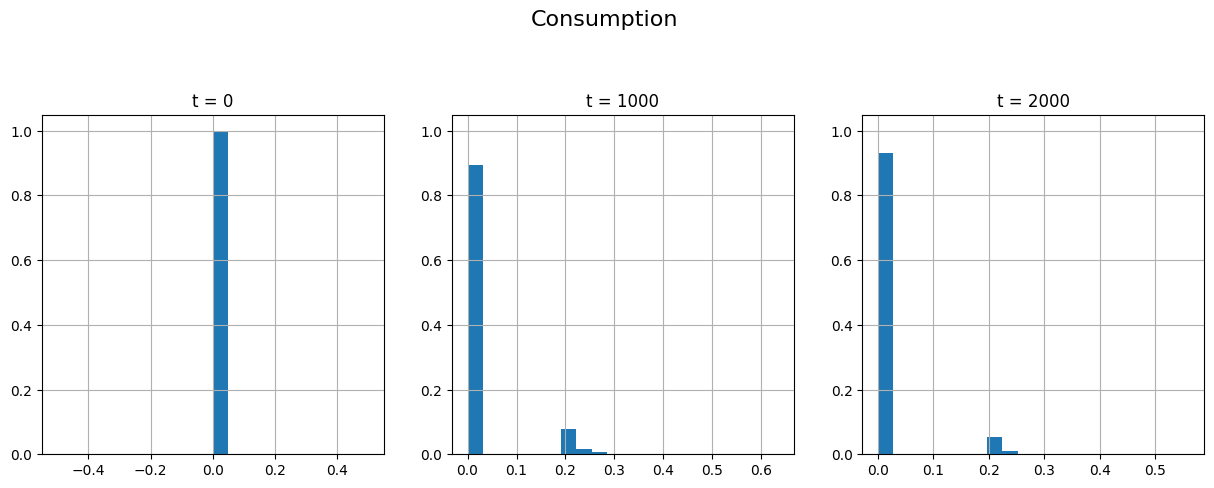

In [32]:
cols = ['wealth', 'animal_spirits', 'political_view', 'moral_behavior', 'consumption']
for c in cols:
  make_hist(c)

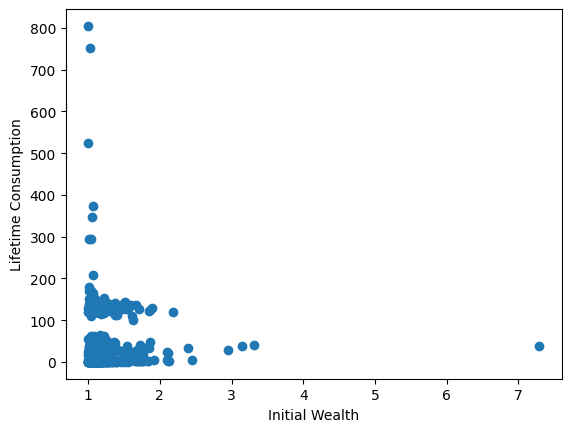

In [33]:
agents_lifetime_consumption = df_agents['consumption'].unstack().sum()
agents_initial_wealth = df_agents['wealth'].unstack().iloc[0,:]

plt.scatter(y = agents_lifetime_consumption, x = agents_initial_wealth);
plt.xlabel('Initial Wealth');
plt.ylabel('Lifetime Consumption');
plt.savefig(f'{to_export}/ini_wealth_life_consumption.png');

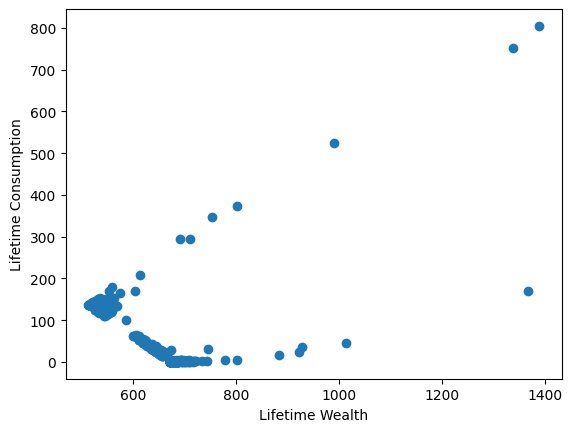

In [34]:
agents_lifetime_consumption = df_agents['consumption'].unstack().sum()
agents_lifetime_wealth = df_agents['wealth'].unstack().sum()

plt.scatter(y = agents_lifetime_consumption, x = agents_lifetime_wealth);
plt.xlabel('Lifetime Wealth');
plt.ylabel('Lifetime Consumption');
plt.savefig(f'{to_export}/life_wealth_life_consumption.png');

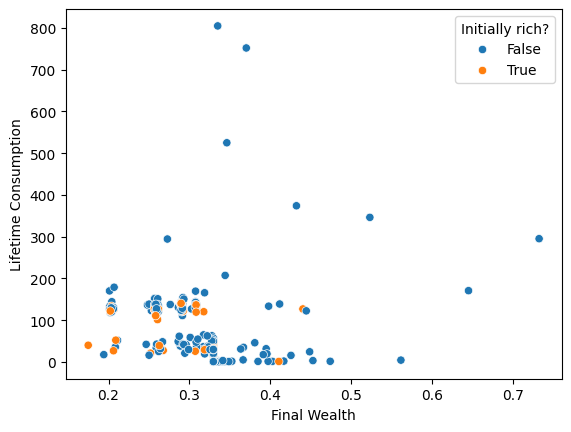

In [48]:
agents_final_wealth = df_agents['wealth'].unstack().iloc[df_model.shape[0] - 1,:]
agents_initial_wealth = df_agents['wealth'].unstack().iloc[0 ,:]
rich = [i > agents_initial_wealth.mean() for i in agents_initial_wealth]

# plt.scatter(y = agents_lifetime_consumption, x = agents_final_wealth, c = rich);
# plt.xlabel('Final Wealth');
# plt.ylabel('Lifetime Consumption');
# plt.legend(title = 'color', );

sns.scatterplot(x = agents_final_wealth, y = agents_lifetime_consumption, hue = rich)
plt.xlabel('Final Wealth');
plt.ylabel('Lifetime Consumption');
plt.legend(title = 'Initially rich?' );
plt.savefig(f'{to_export}/fin_wealth_life_consumption.png');

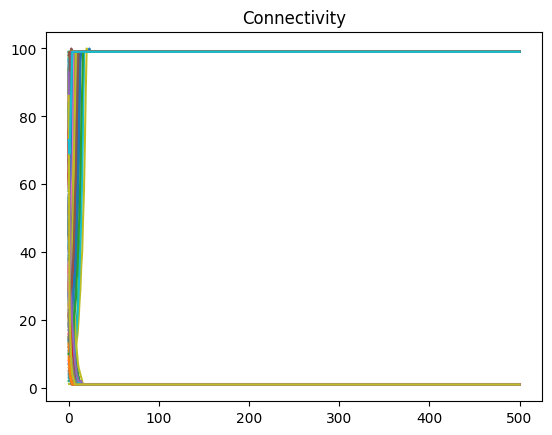

In [ ]:
plt.plot(df_agents['connectivity'].unstack());
plt.title('Connectivity');
plt.savefig(f'{to_export}/connectivity_in_time.png');

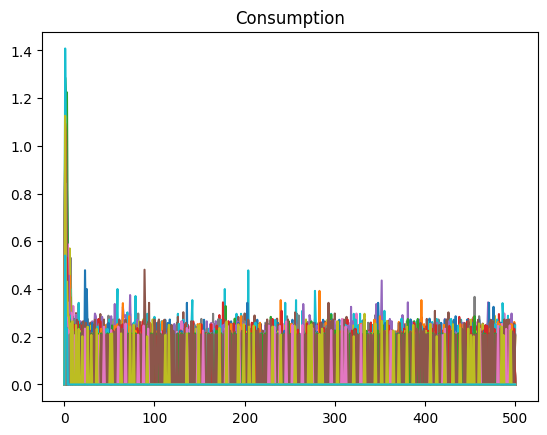

In [ ]:
plt.plot(df_agents['consumption'].unstack());
plt.title('Consumption');
plt.savefig(f'{to_export}/consumption_in_time.png');

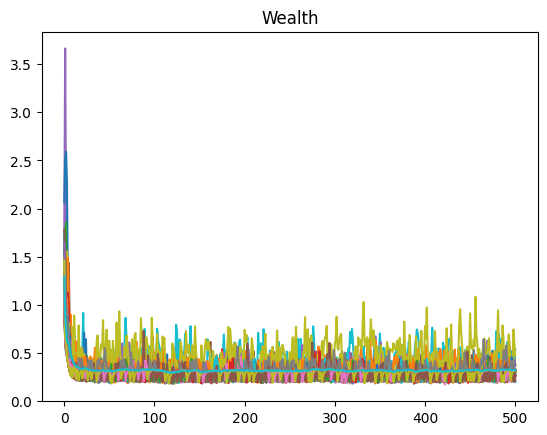

In [ ]:
plt.plot(df_agents['wealth'].unstack());
plt.title('Wealth');
plt.savefig(f'{to_export}/wealth_in_time.png');

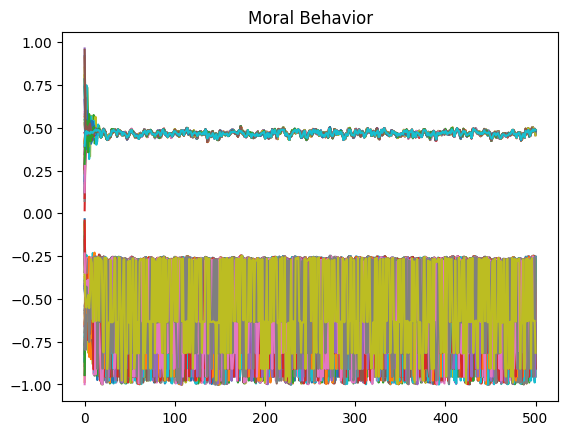

In [ ]:
plt.plot(df_agents['moral_behavior'].unstack());
plt.title('Moral Behavior');
plt.savefig(f'{to_export}/moral_behavior_in_time.png');

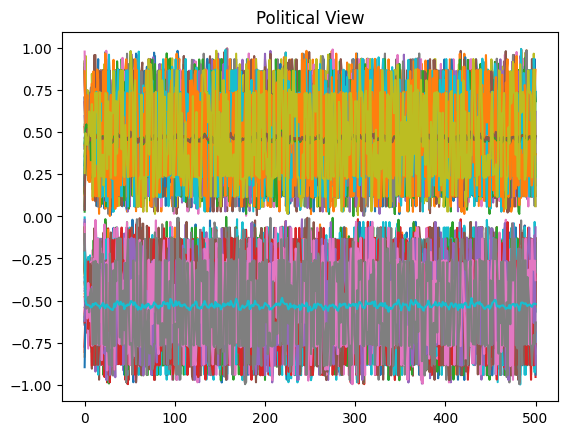

In [ ]:
plt.plot(df_agents['political_view'].unstack());
plt.title('Political View');
plt.savefig(f'{to_export}/political_view_in_t.png');

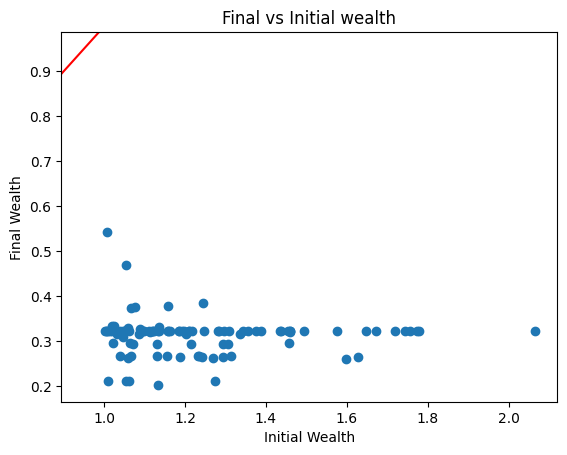

In [ ]:
plt.scatter(x=df_agents['wealth'].unstack().iloc[0,:], y=df_agents['wealth'].unstack().iloc[-1 , :]);
plt.axline((0.95, 0.95), slope = 1, color = 'red');
plt.xlabel('Initial Wealth');
plt.ylabel('Final Wealth');
plt.title('Final vs Initial wealth');
plt.savefig(f'{to_export}/ini_wealth_fin_wealth.png');

## Aggregate, the model

In [ ]:
df_model.head()

,n_agents,tax
0,100,0.000000
1,100,0.491088
2,100,0.511392
3,100,0.529387
4,100,0.529129


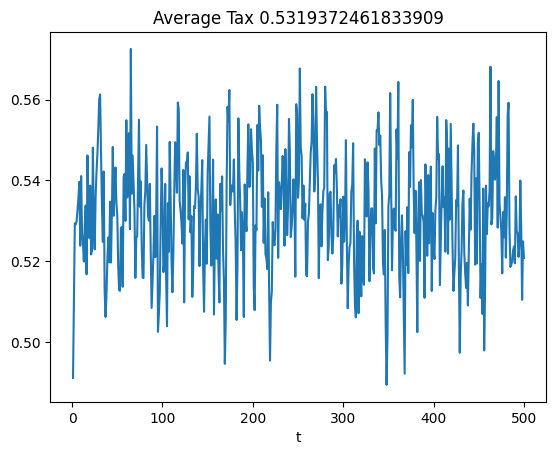

In [ ]:
df_model['tax'].iloc[1:].plot();
plt.title(f'Average Tax {df_model['tax'].iloc[1:].mean()}');
plt.xlabel('t');
plt.savefig(f'{to_export}/tax_in_t.png');

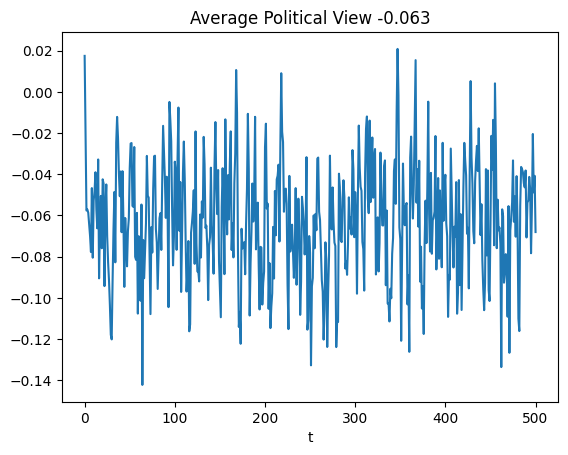

In [ ]:
df_agents['political_view'].unstack().mean(axis = 1).plot();
plt.title(f'Average Political View {np.round(df_agents['political_view'].unstack().mean(axis = 1).mean(), 3)}');
plt.xlabel('t');
plt.savefig(f'{to_export}/political_view_in_t.png');

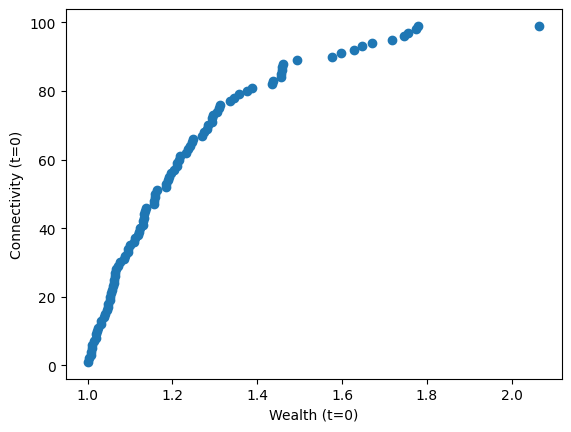

In [ ]:
plt.scatter(
        x = df_agents['wealth'].unstack().iloc[0,:], 
        y = df_agents['connectivity'].unstack().iloc[0,:]
    );
plt.xlabel('Wealth (t=0)');
plt.ylabel('Connectivity (t=0)');
plt.savefig(f'{to_export}/ini_wealth_ini_connectivity.png');

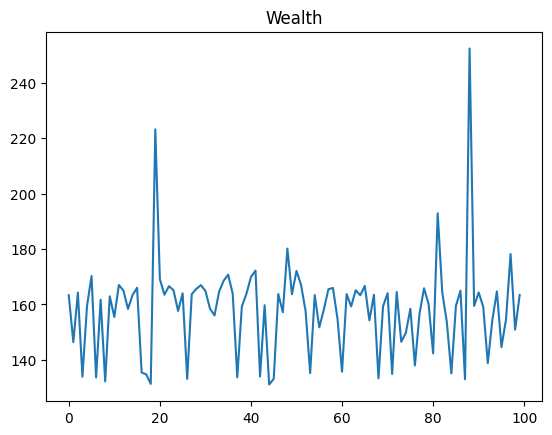

In [ ]:
plt.plot(df_agents['wealth'].unstack().sum());
plt.title('Wealth');